<a href="https://colab.research.google.com/github/trantrongthinh/TH_Time_Series_de_8/blob/main/THM_Time_series_de8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import find_peaks

In [40]:
df = pd.read_csv('/content/drive/MyDrive/Data.csv')
df.head()

,Temperature,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5
0,25.431489,0.677916,0.208399,0.033098,0.145758,0.291933
1,24.486056,0.801851,0.445989,0.869082,0.499015,0.531490
2,20.055087,0.781817,0.040596,0.205773,0.517225,0.598457
3,22.781690,0.651030,0.316018,0.945797,0.433242,0.378673
4,25.292826,0.292357,0.893463,0.289188,0.490347,0.012502


In [41]:
df.describe()

,Temperature,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5
count,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000,3457.000000
mean,24.989396,0.502612,0.496721,0.497600,0.495230,0.496095
std,2.898912,0.290374,0.293774,0.287507,0.287608,0.289214
min,18.982907,0.000243,0.000388,0.000091,0.000244,0.000254
25%,22.542058,0.252100,0.240042,0.249052,0.251254,0.241400
50%,24.972157,0.504355,0.495343,0.506430,0.491202,0.494519
75%,27.396090,0.758330,0.750479,0.750505,0.741194,0.748835
max,31.739198,0.999787,0.999965,0.999586,0.999667,0.999862


In [42]:

# Thiết lập trục thời gian: 7 ngày, mỗi 10 phút/lần
start_time = pd.Timestamp('2024-01-01 00:00:00')
periods = 7 * 24 * 6  # 1008 dòng

time_index = pd.date_range(start=start_time, periods=periods, freq='10T')

# Giữ đúng số dòng (nếu nhiều hơn thì cắt)
df = df.iloc[:periods].copy()
df['Time'] = time_index
df.set_index('Time', inplace=True)

df.head(), df.tail()


<ipython-input-42-c77c0f813867>:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start=start_time, periods=periods, freq='10T')


(                     Temperature   Sensor1   Sensor2   Sensor3   Sensor4  \
 Time                                                                       
 2024-01-01 00:00:00    25.431489  0.677916  0.208399  0.033098  0.145758   
 2024-01-01 00:10:00    24.486056  0.801851  0.445989  0.869082  0.499015   
 2024-01-01 00:20:00    20.055087  0.781817  0.040596  0.205773  0.517225   
 2024-01-01 00:30:00    22.781690  0.651030  0.316018  0.945797  0.433242   
 2024-01-01 00:40:00    25.292826  0.292357  0.893463  0.289188  0.490347   
 
                       Sensor5  
 Time                           
 2024-01-01 00:00:00  0.291933  
 2024-01-01 00:10:00  0.531490  
 2024-01-01 00:20:00  0.598457  
 2024-01-01 00:30:00  0.378673  
 2024-01-01 00:40:00  0.012502  ,
                      Temperature   Sensor1   Sensor2   Sensor3   Sensor4  \
 Time                                                                       
 2024-01-07 23:10:00    29.644237  0.061754  0.752063  0.972043  0.992314

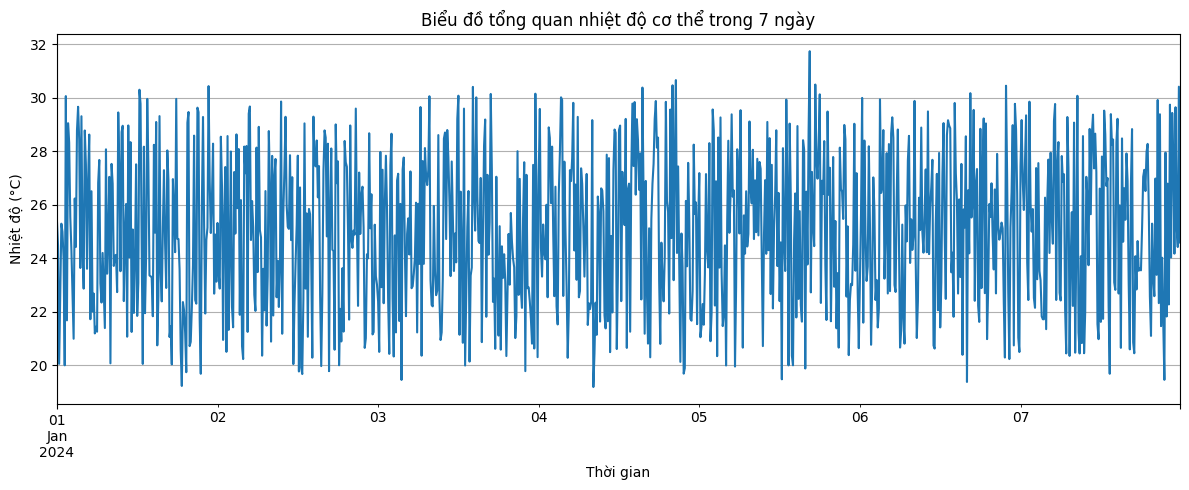

In [43]:
plt.figure(figsize=(12,5))
df['Temperature'].plot()
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ (°C)')
plt.title('Biểu đồ tổng quan nhiệt độ cơ thể trong 7 ngày')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-44-07f79f600230>:15: RuntimeWarning: divide by zero encountered in divide
  hours_per_cycle = 1 / (freqs * 3600)


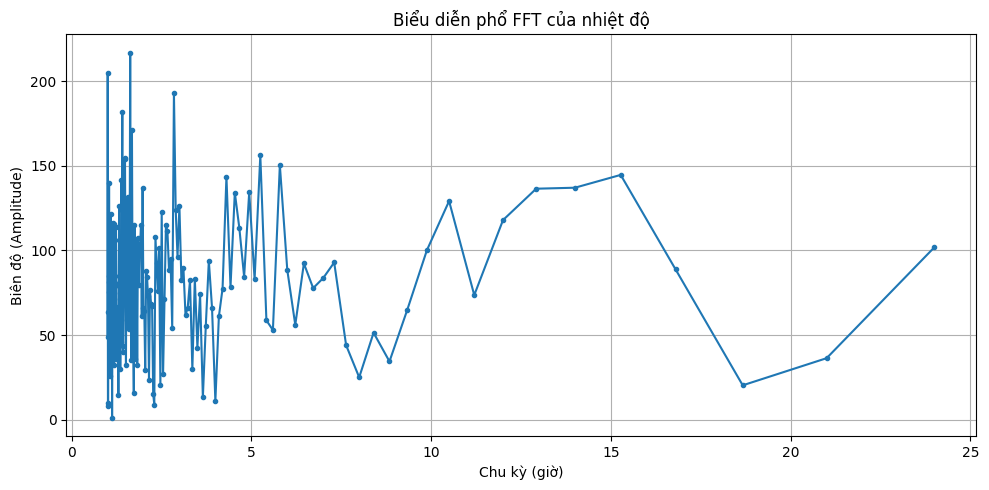

In [44]:
#Biểu diễn phổ và xác định chu trình chính
# Lấy dữ liệu nhiệt độ
temp = df['Temperature'].values
N = len(temp)
dt = 10 * 60

# Trừ giá trị trung bình để loại bỏ offset DC
temp_detrend = temp - np.mean(temp)

# FFT
fft_vals = np.fft.fft(temp_detrend)
freqs = np.fft.fftfreq(N, dt)  # đơn vị Hz

# Chuyển sang chu kỳ (giờ)
hours_per_cycle = 1 / (freqs * 3600)
amplitude = np.abs(fft_vals)[:N//2]  # chỉ lấy nửa phổ đầu

# Lọc các chu kỳ từ 1h đến 24h
mask = (hours_per_cycle[:N//2] >= 1) & (hours_per_cycle[:N//2] <= 24)

# Vẽ phổ biên độ theo chu kỳ (giờ)
plt.figure(figsize=(10,5))
plt.plot(hours_per_cycle[:N//2][mask], amplitude[mask], marker='.')
plt.xlabel('Chu kỳ (giờ)')
plt.ylabel('Biên độ (Amplitude)')
plt.title('Biểu diễn phổ FFT của nhiệt độ')
plt.grid(True)
plt.tight_layout()
plt.show()

# Xác định chu kỳ chính
def find_main_period(amplitude, hours_per_cycle, mask):

  # Lọc vùng quan tâm
    filtered_amplitude = amplitude[mask]
    filtered_hours = hours_per_cycle[mask]
  # Tìm chỉ số có biên độ lớn nhất (đỉnh cao nhất)
    peak_idx = np.argmax(filtered_amplitude)
    main_period = filtered_hours[peak_idx]
    main_ampl = filtered_amplitude[peak_idx]


    return main_period, main_ampl

In [45]:
main_period, main_ampl = find_main_period(amplitude, hours_per_cycle[:N//2], mask)
print("Chu kỳ chính (giờ):", main_period)
print("Biên độ tại chu kỳ đó:", main_ampl)

Chu kỳ chính (giờ): 1.6310679611650485
Biên độ tại chu kỳ đó: 216.73793100162322


<Figure size 600x500 with 0 Axes>

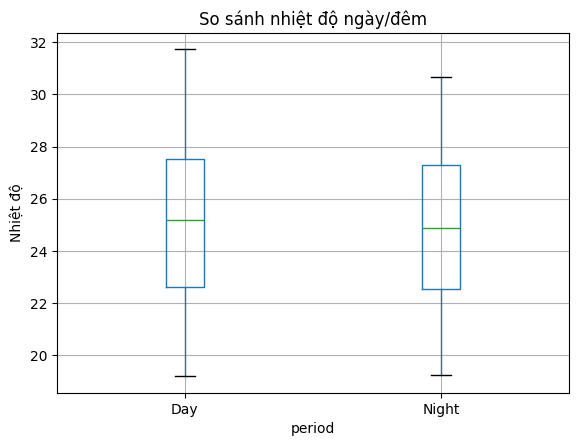

Trung bình nhiệt độ ngày:  25.13708062417513
Trung bình nhiệt độ đêm:  24.886201691471314


In [46]:
# Tạo cột giờ để phân nhóm
df['hour'] = df.index.hour

# Ban ngày: 6h-18h, Ban đêm: còn lại
df['period'] = np.where((df['hour'] >= 6) & (df['hour'] < 18), 'Day', 'Night')

# Trung bình ngày và đêm
mean_day = df[df['period'] == 'Day']['Temperature'].mean()
mean_night = df[df['period'] == 'Night']['Temperature'].mean()

# Boxplot so sánh
plt.figure(figsize=(6,5))
df.boxplot(column='Temperature', by='period')
plt.title('So sánh nhiệt độ ngày/đêm')
plt.suptitle('')
plt.ylabel('Nhiệt độ')
plt.grid(True)
plt.show()

print('Trung bình nhiệt độ ngày: ', mean_day)
print('Trung bình nhiệt độ đêm: ', mean_night)


In [47]:
# Lọc vùng ultradian (< 24h)
ultra_mask = (hours_per_cycle[:N//2] >= 1) & (hours_per_cycle[:N//2] < 24)
ampl_ultra = amplitude[ultra_mask]
hours_ultra = hours_per_cycle[:N//2][ultra_mask]

# Tìm các đỉnh nổi bật trong vùng ultradian
peaks, properties = find_peaks(ampl_ultra, height=np.mean(ampl_ultra) + np.std(ampl_ultra))

# Tạo danh sách các chu kỳ ultradian nổi bật, sắp xếp theo biên độ giảm dần
ultradian_list = []
for i in peaks:
    ultradian_list.append((hours_ultra[i], ampl_ultra[i]))
ultradian_list_sorted = sorted(ultradian_list, key=lambda x: x[1], reverse=True)

# Giờ bạn có thể sử dụng biến ultradian_list_sorted ở bất kỳ bước nào sau này!
print(ultradian_list_sorted[:5])

[(np.float64(1.6310679611650485), np.float64(216.73793100162322)), (np.float64(1.0059880239520957), np.float64(204.6439097729961)), (np.float64(2.847457627118644), np.float64(193.11595785934028)), (np.float64(1.4117647058823528), np.float64(181.47383106430405)), (np.float64(1.6799999999999997), np.float64(171.00180890593407))]


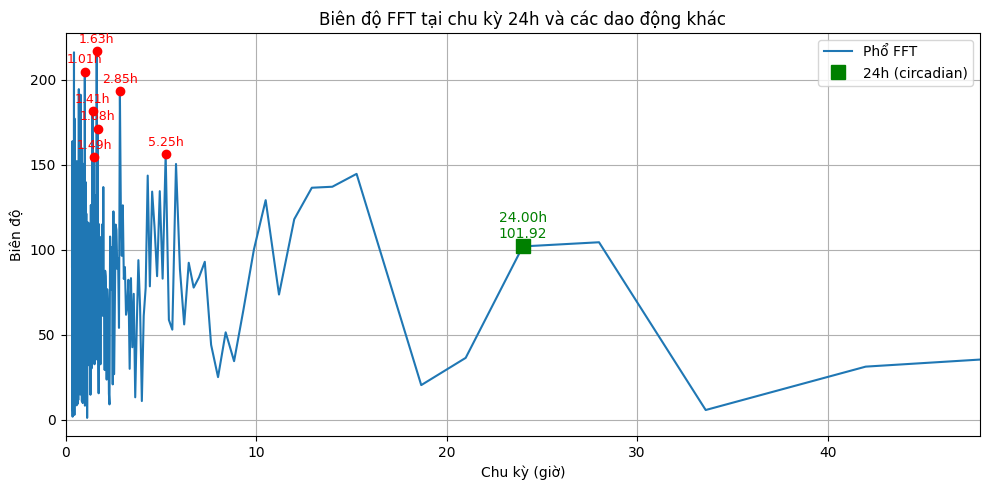

Biên độ tại chu kì 24h:  101.91669895187513


In [48]:
# Tìm vị trí gần nhất với 24h trong phổ FFT
target_period = 24
idx_24h = np.argmin(np.abs(hours_per_cycle[:N//2] - target_period))
amp_24h = amplitude[idx_24h]
period_24h = hours_per_cycle[:N//2][idx_24h]

# Vẽ lại phổ FFT < 48h, đánh dấu đỉnh 24h
plt.figure(figsize=(10,5))
plt.plot(hours_per_cycle[:N//2], amplitude, label='Phổ FFT')
plt.xlim(0, 48)
plt.xlabel('Chu kỳ (giờ)')
plt.ylabel('Biên độ')
plt.title('Biên độ FFT tại chu kỳ 24h và các dao động khác')
plt.grid(True)

# Đánh dấu vị trí 24h
plt.plot(period_24h, amp_24h, 'gs', markersize=10, label='24h (circadian)')
plt.text(period_24h, amp_24h+5, f'{period_24h:.2f}h\n{amp_24h:.2f}', color='green', ha='center', fontsize=10)

# Đánh dấu các đỉnh ultradian nổi bật (chỉ 7 đỉnh lớn nhất)
for cyc, amp in ultradian_list_sorted[:7]:
    plt.plot(cyc, amp, 'ro')
    plt.text(cyc, amp+5, f'{cyc:.2f}h', color='red', ha='center', fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()
print("Biên độ tại chu kì 24h: ", amp_24h)